In [129]:
#########################################################################
# Поведение пользователей на сайте Яндекс.Метрики
#########################################################################


#########################################################################
# Описание API
#
# Список доступных параметров для запросов в Яндекс.Метрике: 
# https://yandex.ru/dev/metrika/doc/api2/api_v1/attrandmetr/dim_all.html
#########################################################################

In [130]:
# Импортируем библиотеки

import pandas as pd
import datetime
import os
import random
import sys
import requests
import json
from urllib.parse import urlencode
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
# Базовый URL сервиса

url = 'https://api-metrika.yandex.net/stat/v1/data?'

In [132]:
# Параметры запроса, разделенные '&', в виде 'имя=значение', взятые с сайта Яндекс.Метрики (отчет по "Визитам пользователей")

visits = 'metrics=ym:s:visits&dimensions=ym:s:date&dimensions=ym:s:isRobot&dimensions=ym:s:browser&id=44147844'
url = url + visits

In [133]:
# Код ответа о статусе "200" указывает, что запрос выполнен успешно

vistis_request = requests.get(url)
vistis_request

<Response [200]>

In [134]:
# Получаем файл json

query = requests.get(url)
json_data = json.loads(query.text)

In [148]:
json_data['data']

[{'dimensions': [{'name': '2022-05-04'},
   {'name': 'People', 'id': 'no'},
   {'icon_id': '6',
    'icon_type': 'browser',
    'name': 'Google Chrome',
    'id': '6'}],
  'metrics': [678.0]},
 {'dimensions': [{'name': '2022-05-05'},
   {'name': 'People', 'id': 'no'},
   {'icon_id': '6',
    'icon_type': 'browser',
    'name': 'Google Chrome',
    'id': '6'}],
  'metrics': [663.0]},
 {'dimensions': [{'name': '2022-05-06'},
   {'name': 'People', 'id': 'no'},
   {'icon_id': '6',
    'icon_type': 'browser',
    'name': 'Google Chrome',
    'id': '6'}],
  'metrics': [559.0]},
 {'dimensions': [{'name': '2022-05-03'},
   {'name': 'People', 'id': 'no'},
   {'icon_id': '6',
    'icon_type': 'browser',
    'name': 'Google Chrome',
    'id': '6'}],
  'metrics': [361.0]},
 {'dimensions': [{'name': '2022-05-07'},
   {'name': 'People', 'id': 'no'},
   {'icon_id': '6',
    'icon_type': 'browser',
    'name': 'Google Chrome',
    'id': '6'}],
  'metrics': [234.0]},
 {'dimensions': [{'name': '2022-05-

In [136]:
# Преобразование полученного json в датафрэйм

visits_data = pd.DataFrame([(
                             i['dimensions'][0]['name'],
                             i['dimensions'][2]['name'],
                             i['dimensions'][1]['name'],
                             i['metrics'][0]) for i in json_data['data']], 
                           columns=['date', 'browser', 'user', 'visits'])
visits_data

,date,browser,user,visits
0,2022-05-04,Google Chrome,People,678.0
1,2022-05-05,Google Chrome,People,663.0
2,2022-05-06,Google Chrome,People,559.0
3,2022-05-03,Google Chrome,People,361.0
4,2022-05-07,Google Chrome,People,234.0
...,...,...,...,...
95,2022-05-06,Android Browser,Robots,4.0
96,2022-05-07,Yandex Browser,Robots,4.0
97,2022-05-08,Android Browser,People,4.0
98,2022-05-04,MIUI,People,3.0


<Figure size 2880x1440 with 0 Axes>

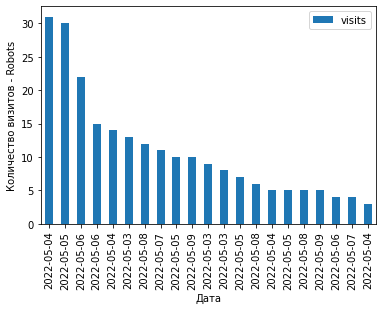

In [137]:
# Посмотрим на распределение посещений сайта по дням. 
# Построим график с распределением количества посещений от ботов и обычных пользователей сайта Яндекс.Метрика

visits_data_people = visits_data.query('user == "People"')
visits_data_robots = visits_data.query('user == "Robots"')

plt.figure(figsize=(40, 20))
visits_data_robots.plot(x = 'date', y = 'visits', kind = 'bar', xlabel = 'Дата', ylabel = 'Количество визитов - Robots')

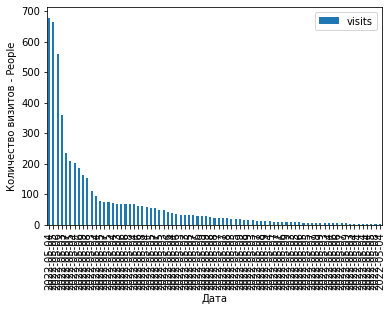

In [138]:
visits_data_people.plot(x = 'date', y = 'visits', kind = 'bar', xlabel = 'Дата', ylabel = 'Количество визитов - People')

In [139]:
# Определим процент посещений сайта Яндекс.Метрики с браузера Google Chrome

count_chrome = visits_data.query('browser == "Google Chrome"').visits.count()
count_visits = visits_data.visits.sum()
round((count_visits/count_chrome) * 0.1, 0)

40.0

In [140]:
# Выясним, с какого браузера приходит больше всего ботов

bots_browser_count = visits_data.query('user == "Robots"').value_counts('browser').sort_values(ascending = False)
bots_browser_count

browser
Google Chrome      7
Yandex Browser     6
Chrome Mobile      3
Edge               2
Opera              2
Android Browser    1
dtype: int64

In [141]:
# Экспортируем преобразованные данные с Яндекс.Метрики в таблицу Google SpreadSheets.
# Укажем адрес электронной почты и путь к нашему файлу с учетными данными

my_mail = 'user@gmail.com'
path_to_credential = 'testapi.json' 
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

In [142]:
# Авторизация

credentials = ServiceAccountCredentials.from_json_keyfile_name(path_to_credential, scope)
gs = gspread.authorize(credentials)

In [143]:
# Создание новой таблицы

spreadsheet_name = 'A new spreadsheet'
sheet = gs.create(spreadsheet_name)

In [144]:
# Настройка прав доступа к новой таблице

sheet.share(my_mail, perm_type='user', role='writer')

In [145]:
# Экспорт датафрэйма в созданную таблицу.
# Задаем новое название для внутреннего листа документа

sheet = 'Yandex_visits'
d2g.upload(visits_data, spreadsheet_name, sheet, credentials=credentials, row_names=True)

<Worksheet 'Yandex_visits' id:905538929>

In [ ]:
# Получение ссылки на созданный документ

sheet = gs.create(spreadsheet_name)
spreadsheet_url = "https://docs.google.com/spreadsheets/d/%s" % sheet.id
spreadsheet_url